#1. Identificação de Sistemas via LSTM RNN para Sistema de Aquecedor SISO

In [ ]:
# import required packages
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

Text(0.5, 0, 'Time (sec)')

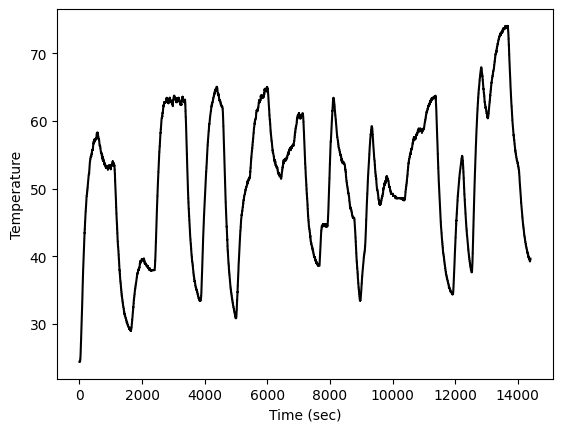

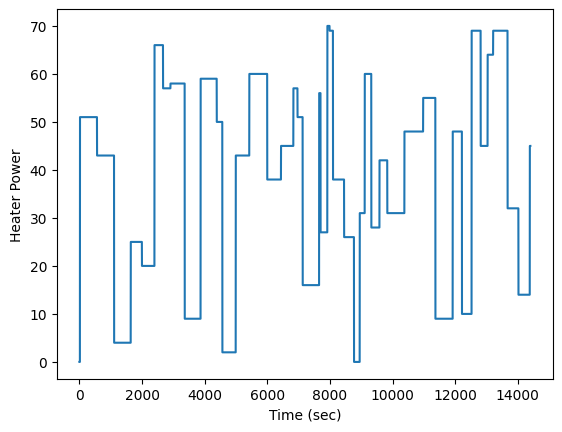

In [ ]:
# read data
data = pd.read_csv('TCLab_train_data.txt')
heaterPower = data[['Q1']].values
temperature = data[['T1']].values

# plot data
plt.plot(temperature, 'k')
plt.ylabel('Temperature')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(heaterPower)
plt.ylabel('Heater Power')
plt.xlabel('Time (sec)')

In [ ]:
# decide model input-outputs and scale data
from sklearn.preprocessing import StandardScaler

X = data[['T1','Q1']].values
y = data[['T1']].values

X_scaler = StandardScaler()
X_scaled = X_scaler.fit_transform(X)

y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

In [ ]:
# rearrange X data into (# sequence samples, # time steps, # features) form
nTimeSteps = 70
X_train_sequence = []
y_train_sequence = []

for sample in range(nTimeSteps, X_scaled.shape[0]):
    X_train_sequence.append(X_scaled[sample-nTimeSteps:sample,:])
    y_train_sequence.append(y_scaled[sample])

# X conversion: convert list of (time steps, features) arrays into (samples, time steps, features) array
X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence)

In [ ]:
#%% import Keras libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

In [ ]:
# define model
model = Sequential()
model.add(LSTM(units=25, kernel_regularizer=regularizers.L1(0.001), input_shape=(nTimeSteps,2)))
model.add(Dense(units=1))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 25)             │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,826 (11.04 KB)

 Trainable params: 2,826 (11.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile model
model.compile(loss='mse', optimizer='Adam')

In [ ]:
# fit model with early stopping
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train_sequence, y_train_sequence, epochs=100, batch_size=250, validation_split=0.3, callbacks=[es])

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.6057 - val_loss: 0.2119
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0601 - val_loss: 0.0900
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0311 - val_loss: 0.0740
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0259 - val_loss: 0.0662
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0221 - val_loss: 0.0600
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 0.0190 - val_loss: 0.0559
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.0165 - val_loss: 0.0511
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0145 - val_loss: 0.0484
Epoch 9/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0128 - val_loss: 0.0453
Epoch 10/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0115 - val_loss: 0.0425
Epoch 11/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0102 - val_loss: 0.0408
Epoch 12/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step

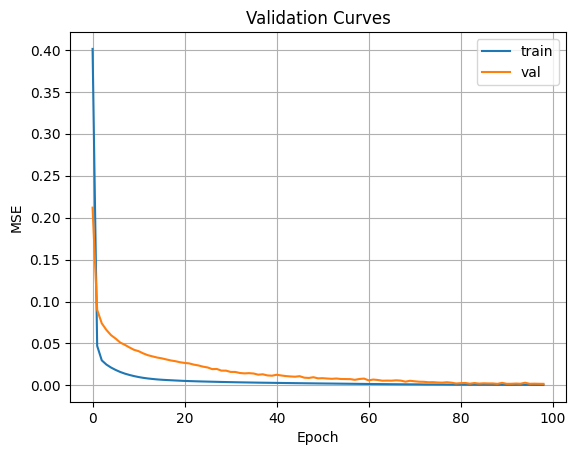

In [ ]:
# plot validation curve
plt.figure()
plt.title('Validation Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.show()

448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step


Text(0.5, 1.0, 'Training data')

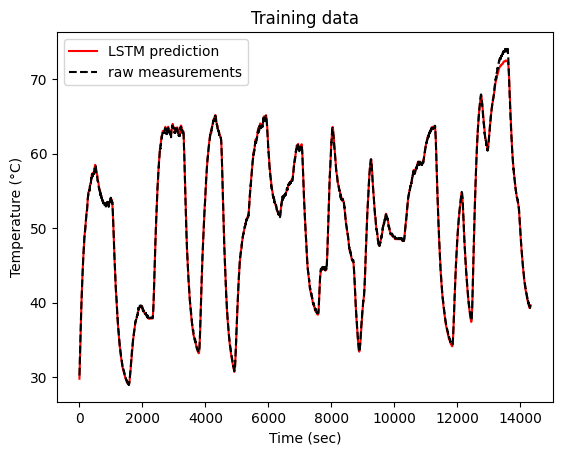

In [ ]:
# check fit on training data
y_train_sequence_pred = model.predict(X_train_sequence)
y_measured = y_scaler.inverse_transform(y_train_sequence)
y_pred =  y_scaler.inverse_transform(y_train_sequence_pred)

# plot
plt.figure()
plt.plot(y_pred, 'r-', label='LSTM prediction')
plt.plot(y_measured, 'k--', label='raw measurements')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Training data')

In [ ]:
# read test data
data_test = pd.read_csv('TCLab_test_data.txt')
X_test = data_test[['T1','Q1']].values
y_test = data_test[['T1']].values

# scale data
X_test_scaled = X_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# re-arrange data into sequence form
X_test_sequence = []
y_test_sequence = []

for sample in range(nTimeSteps, X_test_scaled.shape[0]):
    X_test_sequence.append(X_test_scaled[sample-nTimeSteps:sample,:])
    y_test_sequence.append(y_test_scaled[sample])

X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Text(0.5, 0, 'Time (sec)')

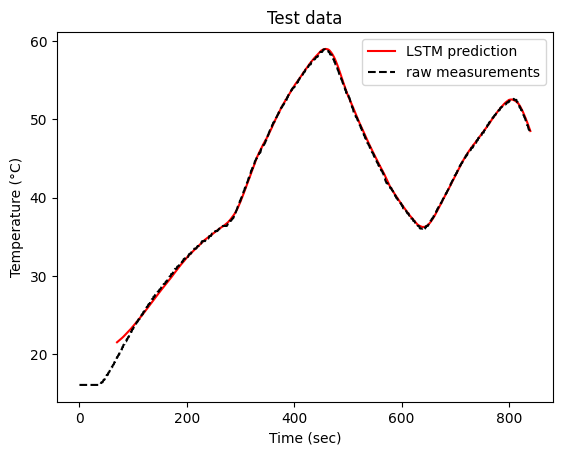

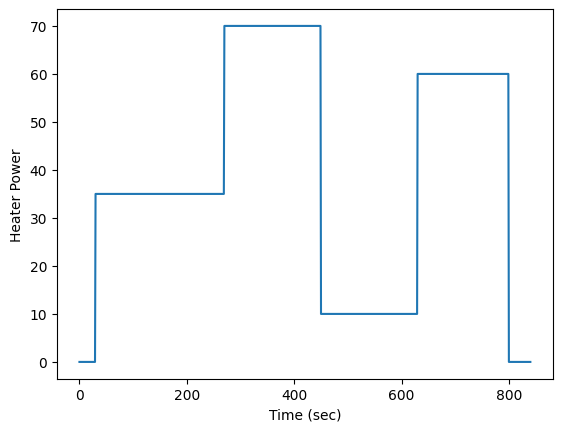

In [ ]:
# predict y_test
y_test_sequence_pred = model.predict(X_test_sequence)
y_test_pred =  y_scaler.inverse_transform(y_test_sequence_pred)

# plot
nRows_test = y_test.shape[0]

# temperature
plt.figure()
plt.plot(np.arange(nTimeSteps, nRows_test), y_test_pred, 'r-', label='LSTM prediction')
plt.plot(np.arange(nRows_test), y_test, 'k--', label='raw measurements')
plt.ylabel('Temperature (°C)')
plt.xlabel('Time (sec)')
plt.legend()
plt.title('Test data')

# heater power
plt.figure()
plt.plot(X_test[:,1])
plt.ylabel('Heater Power')
plt.xlabel('Time (sec)')

#2. Classificação de Falhas via LSTM para o Processo Tennessee Eastman

In [ ]:
!pip install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 8.7 MB/s eta 0:00:00


In [ ]:
# import required packages
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# read data
import pyreadr
fault_free_training_data = pyreadr.read_r('TEP_FaultFree_Training.RData')['fault_free_training'] # pandas dataframe
fault_free_testing_data = pyreadr.read_r('TEP_FaultFree_Testing.RData')['fault_free_testing']
faulty_training_data = pyreadr.read_r('TEP_Faulty_Training.RData')['faulty_training']
faulty_testing_data = pyreadr.read_r('TEP_Faulty_Testing.RData')['faulty_testing']

fault_free_training_data.head()

In [ ]:
# remove fault 3,9,15 data from faulty dataset
faulty_training_data = faulty_training_data[faulty_training_data['faultNumber'] != 3]
faulty_training_data = faulty_training_data[faulty_training_data['faultNumber'] != 9]
faulty_training_data = faulty_training_data[faulty_training_data['faultNumber'] != 15]

faulty_testing_data = faulty_testing_data[faulty_testing_data['faultNumber'] != 3]
faulty_testing_data = faulty_testing_data[faulty_testing_data['faultNumber'] != 9]
faulty_testing_data = faulty_testing_data[faulty_testing_data['faultNumber'] != 15]

In [ ]:
# separate validation dataset out of training dataset and create imbalanced faulty dataset
fault_free_validation_data = fault_free_training_data[fault_free_training_data['simulationRun'] > 400]
fault_free_training_data = fault_free_training_data[fault_free_training_data['simulationRun'] <= 400]
faulty_validation_data = faulty_training_data[faulty_training_data['simulationRun'] > 490]
faulty_training_data = faulty_training_data[faulty_training_data['simulationRun'] <= 50]

# convert to numpy
fault_free_training_data = fault_free_training_data.values
fault_free_validation_data = fault_free_validation_data.values
fault_free_testing_data = fault_free_testing_data.values
faulty_training_data = faulty_training_data.values
faulty_validation_data = faulty_validation_data.values
faulty_testing_data = faulty_testing_data.values

In [ ]:
# complete training, validation, and test datasets
training_data = np.vstack((fault_free_training_data,faulty_training_data))
validation_data = np.vstack((fault_free_validation_data,faulty_validation_data))
testing_data = np.vstack((fault_free_testing_data,faulty_testing_data))

# separate X and y data
X_train = training_data[:,3:]
X_val = validation_data[:,3:]
X_test = testing_data[:,3:]

y_train = training_data[:,0]
y_val = validation_data[:,0]
y_test = testing_data[:,0]

# scale data
from sklearn.preprocessing import StandardScaler

X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# rearrange X data into (# sequence samples, # time steps, # features) form
nTimeStepsTrain = 500 # length of a simulation run in training data
nTimeStepsTest = 960 # length of a simulation run in testing data
X_train_sequence = []
y_train_sequence = []
X_val_sequence = []
y_val_sequence = []
X_test_sequence = []
y_test_sequence = []

for sample in range(0, X_train_scaled.shape[0], nTimeStepsTrain):
    X_train_sequence.append(X_train_scaled[sample:sample+nTimeStepsTrain,:])
    y_train_sequence.append(y_train[sample])

for sample in range(0, X_val_scaled.shape[0], nTimeStepsTrain):
    X_val_sequence.append(X_val_scaled[sample:sample+nTimeStepsTrain,:])
    y_val_sequence.append(y_val[sample])

for sample in range(0, X_test_scaled.shape[0], nTimeStepsTest):
    X_test_sequence.append(X_test_scaled[sample:sample+nTimeStepsTest,:])
    y_test_sequence.append(y_test[sample])

X_train_sequence, y_train_sequence = np.array(X_train_sequence), np.array(y_train_sequence)
X_val_sequence, y_val_sequence = np.array(X_val_sequence), np.array(y_val_sequence)
X_test_sequence, y_test_sequence = np.array(X_test_sequence), np.array(y_test_sequence)

In [ ]:
# convert fault class labels to one-hot encoded form
from tensorflow.keras.utils import to_categorical
Y_train_sequence = to_categorical(y_train_sequence, num_classes=21)
Y_val_sequence = to_categorical(y_val_sequence, num_classes=21)
Y_test_sequence = to_categorical(y_test_sequence, num_classes=21)

In [ ]:
# import packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import regularizers

# define model
model = Sequential()
model.add(LSTM(units=128, kernel_regularizer=regularizers.L1(0.0001), return_sequences=True, input_shape=(nTimeStepsTrain,52)))
model.add(LSTM(units=64, kernel_regularizer=regularizers.L1(0.0001)))
model.add(Dense(21, activation='softmax'))

# model summary
model.summary()

In [ ]:
# compile model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

# fit model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(X_train_sequence, Y_train_sequence, epochs=100, batch_size=250, validation_data=(X_val_sequence,Y_val_sequence), callbacks=[es])

In [ ]:
# plot validation curve
plt.figure()
plt.title('Validation Curves: Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.grid()
plt.show()

plt.figure()
plt.title('Validation Curves: Accuracy')
plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# generate confusion matrix
from sklearn.metrics import confusion_matrix

Y_test_sequence_pred = model.predict(X_test_sequence)
y_test_sequence_pred = np.argmax(Y_test_sequence_pred, axis = 1)
conf_matrix = confusion_matrix(y_test_sequence, y_test_sequence_pred, labels=list(range(21)))

# plot confusion matrix
import seaborn as sn

sn.set(font_scale=1.5) # for label size
sn.heatmap(conf_matrix, fmt='.0f', annot=True, cmap='Blues')
plt.ylabel('True Fault Class', fontsize=35)
plt.xlabel('Predicted Fault Class', fontsize=35)